In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Reshape
from tensorflow.keras import backend as K

In [2]:
def calculate_cer(label, ocr_output):
    label = label.flatten() if isinstance(label, np.ndarray) else np.array(label).flatten()
    ocr_output = ocr_output.flatten() if isinstance(ocr_output, np.ndarray) else np.array(ocr_output).flatten()
    m, n = len(label), len(ocr_output)
    previous_row = list(range(n + 1))
    
    for i in range(1, m + 1):
        current_row = [i] + [0] * n
        for j in range(1, n + 1):
            current_row[j] = previous_row[j - 1] if label[i - 1] == ocr_output[j - 1] else min(previous_row[j - 1], previous_row[j], current_row[j - 1]) + 1
        previous_row = current_row
    
    edit_distance = previous_row[n]
    cer = edit_distance / m
    char_accuracy = 1 - cer

    true_words = ' '.join([str(c) for c in label if c not in ['[', ']', ' ']]) 
    pred_words = ' '.join([str(c) for c in ocr_output if c not in ['[', ']', ' ']]) 
    
    correct_words = sum(1 for true_word, pred_word in zip(true_words, pred_words) if true_word == pred_word)
    word_accuracy = correct_words / len(true_words) if len(true_words) > 0 else 0
    
    return cer, char_accuracy, word_accuracy, edit_distance, true_words



def Encode_labels(labels):
    result = []  
    for label in labels:
        char_list = []
        for c in label:
            if '0' <= c <= '9':
                char_list.append(ord(c) - ord('0'))
            elif 'A' <= c <= 'Z':
                char_list.append(ord(c) - ord('A') + 10)
            else:
                print(f"Invalid character detected in label: {label}")     
        result.append(np.array(char_list))  
    return result

def Decode_labels(encoded_labels):
    result = []  
    for encoded_label in encoded_labels:
        char_list = []
        for code in encoded_label:
            if code < 10:
                char_list.append(chr(code + ord('0')))
            elif 10 <= code < 36:
                char_list.append(chr(code - 10 + ord('A')))
            else:
                print(f"Invalid code detected in encoded label: {encoded_label}")     
        result.append(''.join(char_list))  
    return result


In [3]:

def load_images_and_labels(dataset_dir):
    images = []
    labels = []
    
    for image_folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, image_folder)
        serial = image_folder.split('_')[-1]  
        if len(serial) < 9:
            print(f"Skipping folder {image_folder} because serial length is less than 9.")
            continue
        
        for i in range(1, 10):
            img_path = os.path.join(folder_path, f'{i}_{serial[i-1]}.jpg')
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue  
                
            img = cv2.resize(img, (30, 30)) 
            img = img.astype('float32') / 255.0  
            images.append(img) 
            labels.append( Encode_labels(serial[i-1]))  
            
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

dataset_dir = 'segmented_chars/train'
X_train, y_train = load_images_and_labels(dataset_dir)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

dataset_dir = 'segmented_chars/val'
X_val, y_val = load_images_and_labels(dataset_dir)

print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

dataset_dir = 'segmented_chars/test'
X_test, y_test = load_images_and_labels(dataset_dir)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (9504, 30, 30)
y_train shape: (9504, 1, 1)
X_val shape: (2340, 30, 30)
y_val shape: (2340, 1, 1)
X_test shape: (2970, 30, 30)
y_test shape: (2970, 1, 1)


In [4]:

# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 1)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(36, activation='softmax'))
#model.add(Reshape((9, 36)))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 43264)             0         
                                                                 
 dense (Dense)               (None, 128)               5537920   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 36)                4644      
                                                                 
Total params: 5,561,380
Trainable params: 5,561,380
Non-

In [5]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/10
297/297 [==============================] - 21s 68ms/step - loss: 0.7908 - accuracy: 0.8174 - val_loss: 0.1364 - val_accuracy: 0.9671
Epoch 2/10
297/297 [==============================] - 20s 68ms/step - loss: 0.2280 - accuracy: 0.9389 - val_loss: 0.0553 - val_accuracy: 0.9902
Epoch 3/10
297/297 [==============================] - 19s 66ms/step - loss: 0.1414 - accuracy: 0.9624 - val_loss: 0.0370 - val_accuracy: 0.9932
Epoch 4/10
297/297 [==============================] - 21s 72ms/step - loss: 0.1189 - accuracy: 0.9671 - val_loss: 0.0347 - val_accuracy: 0.9949
Epoch 5/10
297/297 [==============================] - 22s 75ms/step - loss: 0.1048 - accuracy: 0.9701 - val_loss: 0.0395 - val_accuracy: 0.9932
Epoch 6/10
297/297 [==============================] - 20s 68ms/step - loss: 0.0836 - accuracy: 0.9766 - val_loss: 0.0334 - val_accuracy: 0.9953
Epoch 7/10
297/297 [==============================] - 21s 72ms/step - loss: 0.0736 - accuracy: 0.9776 - val_loss: 0.0327 - val_accuracy:

In [6]:
y_pred = model.predict(X_test)

predictions = []
true_labels = []

for i in range(0, y_pred.shape[0], 9):
    batch_pred = np.argmax(y_pred[i:i+9], axis=-1) 
    predictions.append(batch_pred)

for i in range(0, y_test.shape[0], 9):
    batch_true = y_test[i:i+9]  
    true_labels.append(batch_true)

true_labels_flat = [batch_true.flatten() for batch_true in true_labels]

93/93 [==============================] - 2s 15ms/step


In [8]:
cer_scores = []
char_acc_scores = []
word_acc_scores = []

for true, pred in zip(true_labels_flat, predictions):
    cer, char_acc, word_acc, _, t = calculate_cer(true, pred)
    cer_scores.append(cer)
    char_acc_scores.append(char_acc)
    word_acc_scores.append(word_acc)

average_cer = np.mean(cer_scores)
average_char_acc = np.mean(char_acc_scores)
average_word_acc = np.mean(word_acc_scores)

print(f"Average CER: {average_cer:.4f}")
print(f"Average Character Accuracy: {average_char_acc:.4f}")
print(f"Average Word Accuracy: {average_word_acc:.4f}")

Average CER: 0.0067
Average Character Accuracy: 0.9933
Average Word Accuracy: 0.9678


In [9]:
t

'19 22 6 7 0 7 9 1 7'

In [10]:
true_labels_flat[:2]

[array([18, 11,  6,  5,  6,  1,  7,  0,  8]),
 array([19, 15,  6,  9,  1,  1,  8,  4,  9])]

In [11]:
predictions[:2]

[array([18,  8,  6,  5,  6,  1,  7,  0,  8], dtype=int64),
 array([19, 15,  6,  9,  1,  1,  8,  4,  9], dtype=int64)]

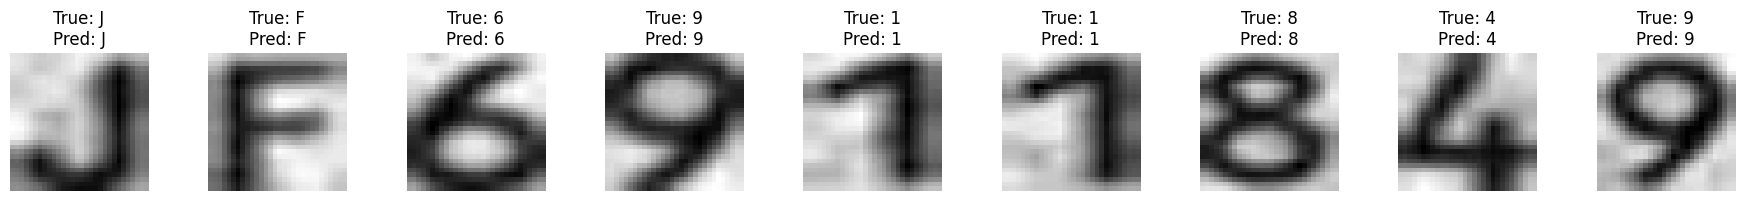

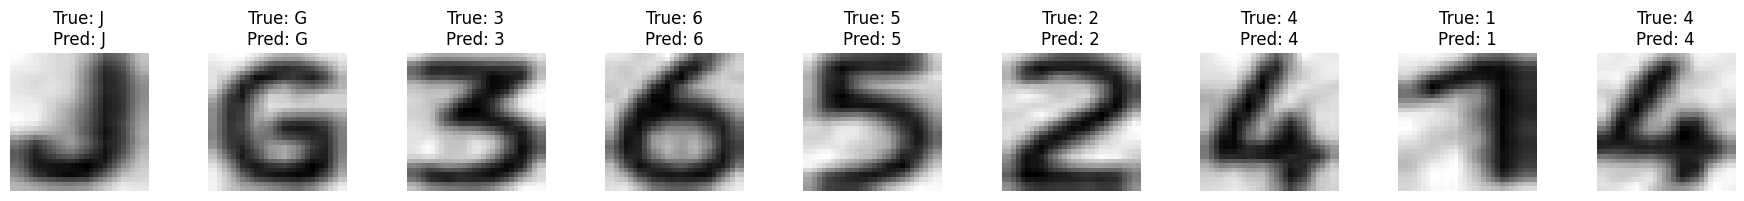

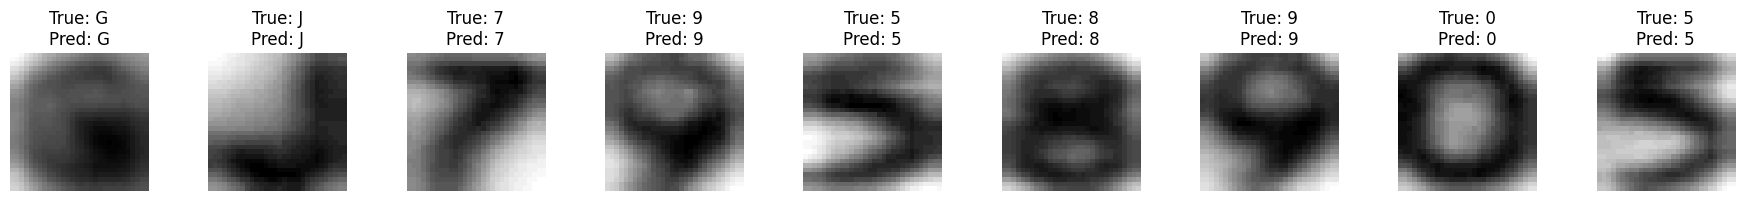

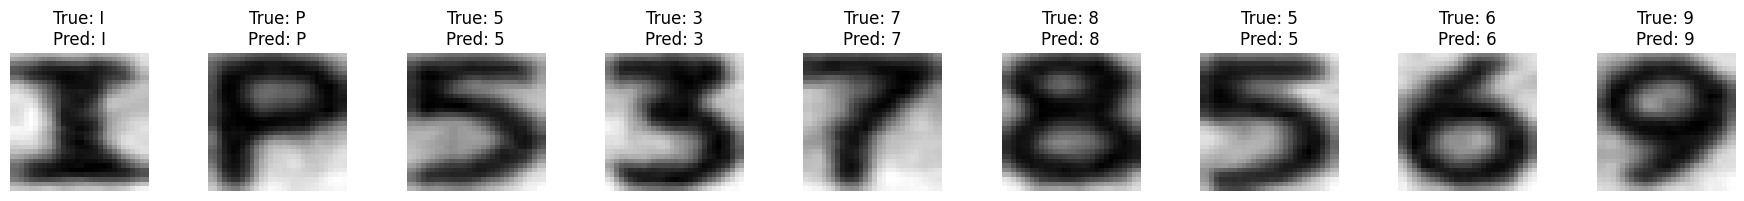

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def decode_label(encoded_label):
    return chr(encoded_label + ord('0')) if encoded_label < 10 else chr(encoded_label - 10 + ord('A'))

true_labels_flat = [batch_true.flatten() for batch_true in true_labels]

for i in range(1, len(predictions[:5])):
    fig, axes = plt.subplots(1, 9, figsize=(18, 2))
    for j in range(9):
        ax = axes[j]
        ax.imshow(X_test[i * 9 + j], cmap='gray')
        ax.axis('off')
        true_label = decode_label(true_labels_flat[i][j])
        pred_label = decode_label(predictions[i][j])
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=12)
    plt.tight_layout()
    plt.show()
